## Character-Level CNN-LSTM model from https://doi.org/10.3390/app131911104

In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

from text_preprocess import clean_text
from results import plot_results

import warnings

warnings.filterwarnings('ignore')

In [2]:
def text_to_one_hot(text):
    
    # English character set
    alphabet = "abcdefghijklmnopqrstuvwxyz "
    unknown_char = "UNK"

    # Create character-to-index mapping
    char_to_index = {char: i for i, char in enumerate(alphabet, start=1)}  # Start index from 1
    char_to_index[unknown_char] = 0  # Index 0 for unknown characters

    # Preprocess input text
    preprocessed_text = clean_text(text)

    # Tokenize the text into character indices
    tokenized_text = [char_to_index.get(char.lower(), char_to_index[unknown_char]) for char in preprocessed_text]
    
    # Zero-pad to fix the length to 350 characters -> Max length of input texts is 349 without preprocess, 326 with preprocess
    max_length = 330
    padded_text = pad_sequences([tokenized_text], maxlen=max_length, padding='post', truncating='post')[0]

    # One-hot encoding
    one_hot_encoding = np.eye(len(alphabet) + 1)[padded_text]  # +1 for the unknown character

    return one_hot_encoding
    

In [3]:
# Load datasets
train_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv")
test_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_test.csv")

####################################################################################
train_df['preprocessed_text'] = train_df['text'].apply(clean_text)
train_df['num_words'] = train_df['preprocessed_text'].apply(lambda x: len(x.split()))

# Find the entry with the maximum number of words
max_words_entry = train_df['num_words'].idxmax()

# Get the corresponding entry from the DataFrame
max_words_text = train_df.loc[max_words_entry, 'preprocessed_text']

print(f"The entry with the maximum number of words has index: {max_words_entry}")
print(f"The maximum number of words is: {train_df['num_words'].max()}")
print(f"The text of the entry is: {max_words_text}")
####################################################################################

# Text preprocessing
X_train_one_hot = train_df['text'].apply(text_to_one_hot)
X_test_one_hot = test_df['text'].apply(text_to_one_hot)

# Binary label encoding
y_train = (train_df['label'] == 'hate').astype(int)
y_test = (test_df['label'] == 'hate').astype(int)

# Convert pandas series to tensorflow tensors
X_train_tensor = tf.convert_to_tensor(X_train_one_hot.tolist(), dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_one_hot.tolist(), dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

The entry with the maximum number of words has index: 1160
The maximum number of words is: 326
The text of the entry is: the reason y i dropped out of school was because either i drop out or i got kicked out i always fought with the packi gang at my school and i was never going to back down in auto class i handed the n igger a monkey wrench and told him the name suited him aswell all the nonwhites hated me because i wore a nazi punk and a white pride patch on my coat and backpack a got in a fight with some black chick and i won the next day her butchy sister caught up with me in the hall way and said that after school her and i where gonna fight i told her no if u wanna fight we re gonna fight right here right now not after school where u can gather the rest of u monkies up so it s an uneven fight she huffed and stormed away we neevr did get to fight the last straw was the first day of school i had a forgein substitute teacher so i was talkin and and this guy was on my case about turni

In [4]:
# Hyperparameters
epochs = 20
batch_size = 32
learning_rate = 0.001
patience = 10
input_shape = (330, 28)

In [5]:
# Char-Level CNN-LSTM Model
char_cnn_lstm_model = Sequential([
    
    # Three convolution layers
    Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=input_shape),
    Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),
    Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),

    # LSTM layer
    LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),

    # Max-pooling layer
    MaxPooling1D(pool_size=3),
    # GlobalMaxPooling1D()
    
    # Flatten layer
    Flatten(),

    # Output layer
    Dense(units=1, activation='sigmoid')
])



In [6]:
# Compile the model
char_cnn_lstm_model.compile(loss='binary_crossentropy',  optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Print the model summary
char_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 328, 256)          21760     
                                                                 
 conv1d_1 (Conv1D)           (None, 326, 256)          196864    
                                                                 
 max_pooling1d (MaxPooling1  (None, 108, 256)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 106, 256)          196864    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 256)           0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 35, 100)           1

In [8]:
# Early stopping
callback = EarlyStopping(monitor='val_loss', patience=patience)

# Train the model
char_cnn_lstm_history = char_cnn_lstm_model.fit(X_train_tensor, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[callback])

Epoch 1/20


48/48 [==============================] - 8s 92ms/step - loss: 0.6535 - accuracy: 0.6257 - val_loss: 0.6419 - val_accuracy: 0.6684
Epoch 2/20
48/48 [==============================] - 4s 78ms/step - loss: 0.6520 - accuracy: 0.6290 - val_loss: 0.6319 - val_accuracy: 0.6345
Epoch 3/20
48/48 [==============================] - 4s 74ms/step - loss: 0.6336 - accuracy: 0.6336 - val_loss: 0.6252 - val_accuracy: 0.6684
Epoch 4/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6255 - accuracy: 0.6434 - val_loss: 0.6119 - val_accuracy: 0.6658
Epoch 5/20
48/48 [==============================] - 4s 82ms/step - loss: 0.6062 - accuracy: 0.6597 - val_loss: 0.5902 - val_accuracy: 0.6841
Epoch 6/20
48/48 [==============================] - 4s 77ms/step - loss: 0.5880 - accuracy: 0.6826 - val_loss: 0.5623 - val_accuracy: 0.7023
Epoch 7/20
48/48 [==============================] - 4s 78ms/step - loss: 0.5270 - accuracy: 0.7413 - val_loss: 0.5963 - val_accuracy: 0.6893
Epoch 8/20


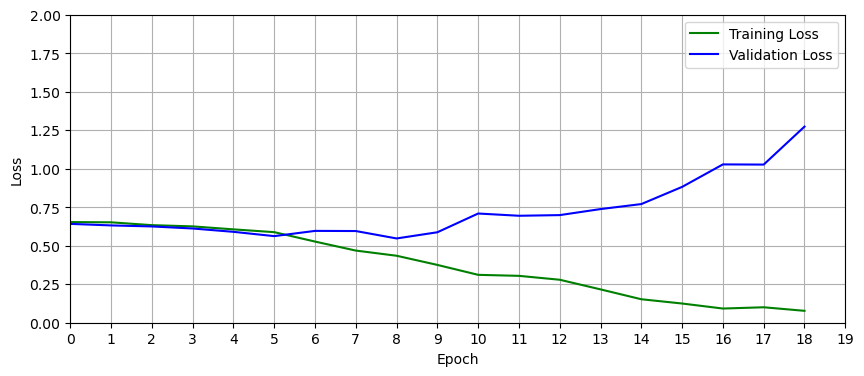

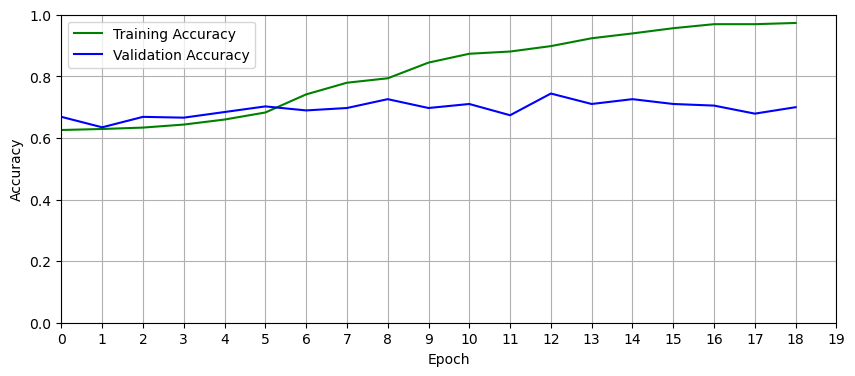

In [9]:
# Retrieve training results
train_loss = char_cnn_lstm_history.history["loss"]
train_acc  = char_cnn_lstm_history.history["accuracy"]
valid_loss = char_cnn_lstm_history.history["val_loss"]
valid_acc  = char_cnn_lstm_history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 2.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"], epochs=epochs);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"], epochs=epochs)

In [11]:
test_loss, test_acc = char_cnn_lstm_model.evaluate(X_test_tensor, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

y_pred = char_cnn_lstm_model.predict(X_test_tensor)

# Convert predictions to binary values (0 or 1) based on a threshold
threshold = 0.5
y_pred_binary = [1 if pred > threshold else 0 for pred in y_pred]

# Evaluate the performance using metrics like accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

print('\n')
print(classification_report(y_test, y_pred_binary, target_names=['noHate', 'hate']))

15/15 [==============================] - 0s 19ms/step - loss: 1.1725 - accuracy: 0.7155
Test accuracy: 71.548
15/15 [==============================] - 0s 20ms/step
F1 Score: 0.7154811715481171
Precision: 0.7154811715481172
Recall: 0.7154811715481172


              precision    recall  f1-score   support

      noHate       0.72      0.72      0.72       239
        hate       0.72      0.72      0.72       239

    accuracy                           0.72       478
   macro avg       0.72      0.72      0.72       478
weighted avg       0.72      0.72      0.72       478

